In [35]:
import pandas as pd
import numpy as np
from ast import literal_eval

from nltk import sentiment
from nltk.corpus import stopwords

import string

from sklearn.feature_extraction.text import CountVectorizer

import re

from nltk.tokenize import word_tokenize

from textatistic import Textatistic

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [4]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/pjzzzz/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /Users/pjzzzz/nltk_data...
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/pjzzzz/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pjzzzz/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pjzzzz/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pjzzzz/nltk_data...


True

In [7]:
#nltk
# processed_df = pd.read_csv('data/preprocessed.csv',
#                            usecols=['headline',
#                                     'headline_cleaned',
#                                     'tokenized_text_nltk',
#                                     'pos_tagged_text_nltk',
#                                     'lemmatized_text_nltk',
#                                     'is_sarcastic'],
#                            converters={'tokenized_text_nltk': literal_eval,
#                                        'pos_tagged_text_nltk': literal_eval,
#                                        'lemmatized_text_nltk': literal_eval})

#spacy
processed_df = pd.read_csv('data/preprocessed.csv',
                           usecols=['headline',
                                    'headline_cleaned',
                                    'tokenized_text_spacy',
                                    'pos_tagged_text_spacy',
                                    'lemmatized_text_spacy',
                                    'is_sarcastic'],
                           converters={'tokenized_text_spacy': literal_eval,
                                       'pos_tagged_text_spacy': literal_eval,
                                       'lemmatized_text_spacy': literal_eval})

print(processed_df.shape)
processed_df.head()


(26709, 6)


,headline,is_sarcastic,headline_cleaned,tokenized_text_spacy,pos_tagged_text_spacy,lemmatized_text_spacy
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret bl...,"[former, versace, store, clerk, sues, over, se...","[(former, JJ), (versace, NN), (store, NN), (cl...","[former, versace, store, clerk, sue, over, sec..."
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catches up to our thorny ...,"[the, roseanne, revival, catches, up, to, our,...","[(the, DT), (roseanne, NNP), (revival, NNP), (...","[the, roseanne, revival, catch, up, to, our, t..."
2,mom starting to fear son's web series closest ...,1,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c...","[(mom, NN), (starting, VBG), (to, TO), (fear, ...","[mom, start, to, fear, son, web, series, close..."
3,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ...","[(boehner, NN), (just, RB), (wants, VBZ), (wif...","[boehner, just, want, wife, to, listen, not, c..."
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday in the ...,"[jk, rowling, wishes, snape, happy, birthday, ...","[(jk, NNP), (rowling, NNP), (wishes, VBZ), (sn...","[jk, rowling, wish, snape, happy, birthday, in..."


# Create New Features from Text

In [8]:
def get_punctuations(headline):
    """
    Helper function to get punctuation count from headlines
    """
    count = 0
    for punc in string.punctuation:
        count += headline.count(punc)
    return count

In [9]:
def get_unique_repeated(headline):
    """
    Helper function to get unique and repeated words from sentences
    """
    try:
        vec = CountVectorizer(ngram_range=(1, 1), stop_words=None)
        bow = vec.fit_transform([headline])

        sum_of_words = bow.sum(axis=0)

        unigram_freq = [(word, sum_of_words[0, i]) for word, i in vec.vocabulary_.items()]

        unigram_freq = pd.DataFrame(unigram_freq, columns=['word', 'freq'])

        #number of unique words
        num_unique = len(unigram_freq[unigram_freq.freq == 1])
        #number of repeated words
        num_repeated = len(unigram_freq[unigram_freq.freq > 1])

        return [num_unique, num_repeated]
    except:
        try:
        #deals with headlines that only contain stopwords
            headline = headline.replace(' ', '')
            vec = CountVectorizer(ngram_range=(1, 1), stop_words=None)
            bow = vec.fit_transform([headline])

            sum_of_words = bow.sum(axis=0)

            unigram_freq = [(word, sum_of_words[0, i]) for word, i in vec.vocabulary_.items()]

            unigram_freq = pd.DataFrame(unigram_freq, columns=['word', 'freq'])

            #number of unique words
            num_unique = len(unigram_freq[unigram_freq.freq == 1])
            #number of repeated words
            num_repeated = len(unigram_freq[unigram_freq.freq > 1])

            return [num_unique, num_repeated]
        except:
            #empty strings
            return [0, 0]

In [10]:
def get_word_tag_count(text_tag):
    """
    Returns count of parts of speech (POS) tags from text_tag
    """
    noun_count = len([w for w in text_tag if w[1].startswith('NN')])
    adjective_count = len([w for w in text_tag if w[1].startswith('JJ')])
    verb_count = len([w for w in text_tag if w[1].startswith('VB')])

    return [noun_count, adjective_count, verb_count]

In [11]:
def count_regexp_occ(regexp="", text=None):
    """
    Returns count of occurrences of specified Regex pattern
    """
    return len(re.findall(regexp, text))

In [12]:
def readability(text):
    """
    Helper function to get readability score of a piece of text.
    """

    #hyphenated words should not have more than 100 characters
    text = text.replace('_', ' ')
    try:
        return Textatistic(text).flesch_score
    except:
        try:
            text += '.'
            score = Textatistic(text).flesch_score
            return score
        except:
            return 0


In [13]:
def sentiment(text):
    """
    Helper function to get sentiment score of a piece of text.
    """
    sentiments = SentimentIntensityAnalyzer()
    score = sentiments.polarity_scores(text)['compound']
    return score

In [14]:
def add_features(data):
    feature_df = data.copy()

    print('Getting Length of headline')
    feature_df['headline_length'] = feature_df['headline'].apply(len)

    print('Creating Word Features')
    # feature_df['num_words'] = feature_df['tokenized_text_nltk'].apply(len)
    feature_df['num_words'] = feature_df['tokenized_text_spacy'].apply(len)
    #number of words vs length of headline
    feature_df['num_words_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_words'] / feature_df['headline_length'], 0)
    #length of headline vs number of words
    feature_df['length_vs_num_words'] = np.where(feature_df['num_words'] > 0, feature_df['headline_length'] / feature_df['num_words'], 0)

    #stopwords
    print('Creating Stopword features')
    stop_words = set(stopwords.words('english'))

    # feature_df['num_stopwords'] = feature_df['tokenized_text_nltk'].apply(lambda x: len([word for word in x if word in stop_words]))
    feature_df['num_stopwords'] = feature_df['tokenized_text_spacy'].apply(lambda x: len([word for word in x if word in stop_words]))


    #number of stopwords vs length of headline
    feature_df['stopwords_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_stopwords'] / feature_df['headline_length'], 0)

    #number of stopwords vs words in headline
    feature_df['stopwords_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_stopwords'] / feature_df['num_words'], 0)

    #Exclamation Mark Features
    # number of exclamation marks
    feature_df['num_exclamation_marks'] = feature_df['headline'].apply(lambda x: x.count('!'))
    #exclamation marks vs length of headline
    feature_df['exclamation_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_exclamation_marks'] / feature_df['headline_length'], 0)

    #exclamation marks vs words
    feature_df['exclamation_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_exclamation_marks'] / feature_df['num_words'], 0)

    #Question Mark Features
    # number of question marks
    feature_df['num_question_marks'] = feature_df['headline'].apply(lambda x: x.count('?'))
    #Question marks vs length of headline
    feature_df['question_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_question_marks'] / feature_df['headline_length'], 0)

    #Question marks vs words
    feature_df['question_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_question_marks'] / feature_df['num_words'], 0)


    #Quotation Mark Features
    # number of quotation marks
    feature_df['num_quotation_marks'] = feature_df['headline'].apply(lambda x: x.count('"'))
    #Question marks vs length of headline
    feature_df['quotation_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_quotation_marks'] / feature_df['headline_length'], 0)

    #Question marks vs words
    feature_df['quotation_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_quotation_marks'] / feature_df['num_words'], 0)

    #Single Quotation Mark Features
    # number of quotation marks
    feature_df['num_single_quotation_marks'] = feature_df['headline'].apply(lambda x: x.count("'"))
    #Question marks vs length of headline
    feature_df['single_quotation_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_single_quotation_marks'] / feature_df['headline_length'], 0)

    #Question marks vs words
    feature_df['single_quotation_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_single_quotation_marks'] / feature_df['num_words'], 0)

    #Punctuation Mark Features
    # number of punctuation marks
    feature_df['num_punctuation_marks'] = feature_df['headline'].apply(get_punctuations)

    #Punctuation marks vs length of headline
    feature_df['punctuation_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_punctuation_marks'] / feature_df['headline_length'], 0)

    #Punctuation marks vs words
    feature_df['punctuation_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_punctuation_marks'] / feature_df['num_words'], 0)

    print('Creating Unique and Repeated word features')
    unique_repeated = feature_df['headline_cleaned'].apply(get_unique_repeated)

    feature_df['num_unique_words'] = unique_repeated.apply(lambda x: x[0])
    feature_df['num_repeated_words'] = unique_repeated.apply(lambda x: x[1])

    #Unique words vs length
    feature_df['unique_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_unique_words'] / feature_df['headline_length'], 0)

    #Unique words vs words
    feature_df['unique_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_unique_words'] / feature_df['num_words'], 0)

    #Repeated words vs length
    feature_df['repeated_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_repeated_words'] / feature_df['headline_length'], 0)

    #Unique words vs words
    feature_df['repeated_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_repeated_words'] / feature_df['num_words'], 0)

    #Word Tag Features
    print('Creating POS Tag Features')
    # word_tag = feature_df['pos_tagged_text_nltk'].apply(get_word_tag_count)
    word_tag = feature_df['pos_tagged_text_spacy'].apply(get_word_tag_count)
    feature_df['num_nouns'] = word_tag.apply(lambda x: x[0])
    feature_df['num_adjectives'] = word_tag.apply(lambda x: x[1])
    feature_df['num_verbs'] = word_tag.apply(lambda x: x[2])

    #Nouns vs length
    feature_df['nouns_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_nouns'] / feature_df['headline_length'], 0)

    #Nouns vs words
    feature_df['nouns_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_nouns'] / feature_df['num_words'], 0)

    #Adjectives vs length
    feature_df['adjectives_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_adjectives'] / feature_df['headline_length'], 0)

    #Adjectives vs words
    feature_df['adjectives_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_adjectives'] / feature_df['num_words'], 0)

    #verbs vs length
    feature_df['verbs_vs_length'] = np.where(feature_df['headline_length'] > 0, feature_df['num_verbs'] / feature_df['headline_length'], 0)

    #verbs vs words
    feature_df['verbs_vs_words'] = np.where(feature_df['num_words'] > 0, feature_df['num_verbs'] / feature_df['num_words'], 0)

    #Readability, Sentiment Analysis
    print('Creating Text Analysis features')
    feature_df['readability'] = feature_df['headline'].apply(readability)
    feature_df['sentiment'] = feature_df['headline'].apply(sentiment)

    return feature_df

In [15]:
feature_df = add_features(processed_df)

Getting Length of headline
Creating Word Features
Creating Stopword features
Creating Unique and Repeated word features
Creating POS Tag Features
Creating Text Analysis features


In [16]:
feature_df.head()

,headline,is_sarcastic,headline_cleaned,tokenized_text_spacy,pos_tagged_text_spacy,lemmatized_text_spacy,headline_length,num_words,num_words_vs_length,length_vs_num_words,...,num_adjectives,num_verbs,nouns_vs_length,nouns_vs_words,adjectives_vs_length,adjectives_vs_words,verbs_vs_length,verbs_vs_words,readability,sentiment
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret bl...,"[former, versace, store, clerk, sues, over, se...","[(former, JJ), (versace, NN), (store, NN), (cl...","[former, versace, store, clerk, sue, over, sec...",78,12,0.153846,6.500000,...,3,1,0.076923,0.500000,0.038462,0.250000,0.012821,0.083333,67.755000,0.0000
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catches up to our thorny ...,"[the, roseanne, revival, catches, up, to, our,...","[(the, DT), (roseanne, NNP), (revival, NNP), (...","[the, roseanne, revival, catch, up, to, our, t...",84,14,0.166667,6.000000,...,4,1,0.035714,0.214286,0.047619,0.285714,0.011905,0.071429,77.810714,-0.3182
2,mom starting to fear son's web series closest ...,1,mom starting to fear sons web series closest t...,"[mom, starting, to, fear, sons, web, series, c...","[(mom, NN), (starting, VBG), (to, TO), (fear, ...","[mom, start, to, fear, son, web, series, close...",79,14,0.177215,5.642857,...,1,4,0.063291,0.357143,0.012658,0.071429,0.050633,0.285714,83.853571,-0.4939
3,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up ...,"[boehner, just, wants, wife, to, listen, not, ...","[(boehner, NN), (just, RB), (wants, VBZ), (wif...","[boehner, just, want, wife, to, listen, not, c...",84,13,0.154762,6.461538,...,1,3,0.047619,0.307692,0.011905,0.076923,0.035714,0.230769,71.767857,0.0000
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday in the ...,"[jk, rowling, wishes, snape, happy, birthday, ...","[(jk, NNP), (rowling, NNP), (wishes, VBZ), (sn...","[jk, rowling, wish, snape, happy, birthday, in...",64,11,0.171875,5.818182,...,2,1,0.078125,0.454545,0.031250,0.181818,0.015625,0.090909,85.888864,0.6486


In [55]:
# feature_df_nltk = feature_df[['headline',
#  'headline_cleaned',
#  'tokenized_text_nltk',
#  'pos_tagged_text_nltk',
#  'lemmatized_text_nltk',
#  'headline_length',
#  'num_words',
#  'num_words_vs_length',
#  'length_vs_num_words',
#  'num_stopwords',
#  'stopwords_vs_length',
#  'stopwords_vs_words',
#  'num_exclamation_marks',
#  'exclamation_vs_length',
#  'exclamation_vs_words',
#  'num_question_marks',
#  'question_vs_length',
#  'question_vs_words',
#  'num_quotation_marks',
#  'quotation_vs_length',
#  'quotation_vs_words',
#  'num_single_quotation_marks',
#  'single_quotation_vs_length',
#  'single_quotation_vs_words',
#  'num_punctuation_marks',
#  'punctuation_vs_length',
#  'punctuation_vs_words',
#  'num_unique_words',
#  'num_repeated_words',
#  'unique_vs_length',
#  'unique_vs_words',
#  'repeated_vs_length',
#  'repeated_vs_words',
#  'num_nouns',
#  'num_adjectives',
#  'num_verbs',
#  'nouns_vs_length',
#  'nouns_vs_words',
#  'adjectives_vs_length',
#  'adjectives_vs_words',
#  'verbs_vs_length',
#  'verbs_vs_words',
#  'readability',
#  'sentiment',
# 'is_sarcastic']]

In [17]:
feature_df_spacy = feature_df[['headline',
 'headline_cleaned',
 'tokenized_text_spacy',
 'pos_tagged_text_spacy',
 'lemmatized_text_spacy',
 'headline_length',
 'num_words',
 'num_words_vs_length',
 'length_vs_num_words',
 'num_stopwords',
 'stopwords_vs_length',
 'stopwords_vs_words',
 'num_exclamation_marks',
 'exclamation_vs_length',
 'exclamation_vs_words',
 'num_question_marks',
 'question_vs_length',
 'question_vs_words',
 'num_quotation_marks',
 'quotation_vs_length',
 'quotation_vs_words',
 'num_single_quotation_marks',
 'single_quotation_vs_length',
 'single_quotation_vs_words',
 'num_punctuation_marks',
 'punctuation_vs_length',
 'punctuation_vs_words',
 'num_unique_words',
 'num_repeated_words',
 'unique_vs_length',
 'unique_vs_words',
 'repeated_vs_length',
 'repeated_vs_words',
 'num_nouns',
 'num_adjectives',
 'num_verbs',
 'nouns_vs_length',
 'nouns_vs_words',
 'adjectives_vs_length',
 'adjectives_vs_words',
 'verbs_vs_length',
 'verbs_vs_words',
 'readability',
 'sentiment',
'is_sarcastic']]

In [18]:
# feature_df_nltk.to_csv('data/features_nltk.csv', index=False)
feature_df_spacy.to_csv('data/features_spacy.csv', index=False)


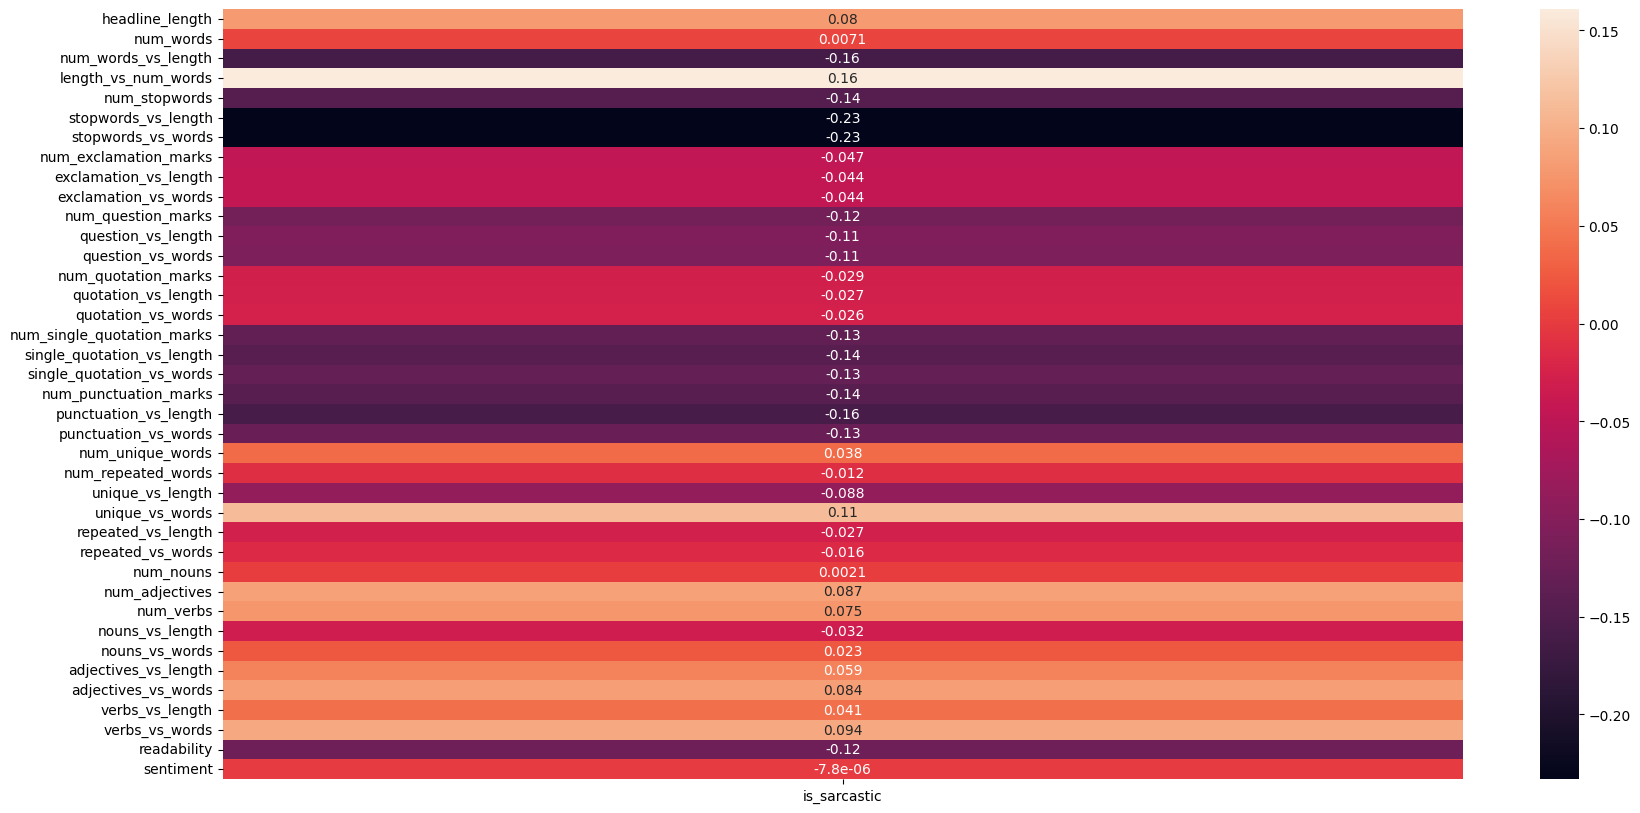

In [19]:
features_spacy = [
'headline_length',
'num_words',
'num_words_vs_length',
'length_vs_num_words',
'num_stopwords',
'stopwords_vs_length',
'stopwords_vs_words',
'num_exclamation_marks',
'exclamation_vs_length',
'exclamation_vs_words',
'num_question_marks',
'question_vs_length',
'question_vs_words',
'num_quotation_marks',
'quotation_vs_length',
'quotation_vs_words',
'num_single_quotation_marks',
'single_quotation_vs_length',
'single_quotation_vs_words',
'num_punctuation_marks',
'punctuation_vs_length',
'punctuation_vs_words',
'num_unique_words',
'num_repeated_words',
'unique_vs_length',
'unique_vs_words',
'repeated_vs_length',
'repeated_vs_words',
'num_nouns',
'num_adjectives',
'num_verbs',
'nouns_vs_length',
'nouns_vs_words',
'adjectives_vs_length',
'adjectives_vs_words',
'verbs_vs_length',
'verbs_vs_words',
'readability',
'sentiment']

rows = [{'is_sarcastic':feature_df_spacy[f].corr(feature_df_spacy['is_sarcastic'])} for f in features_spacy]
train_correlations = pd.DataFrame(rows, index=features_spacy)
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations, annot=True)
plt.show()

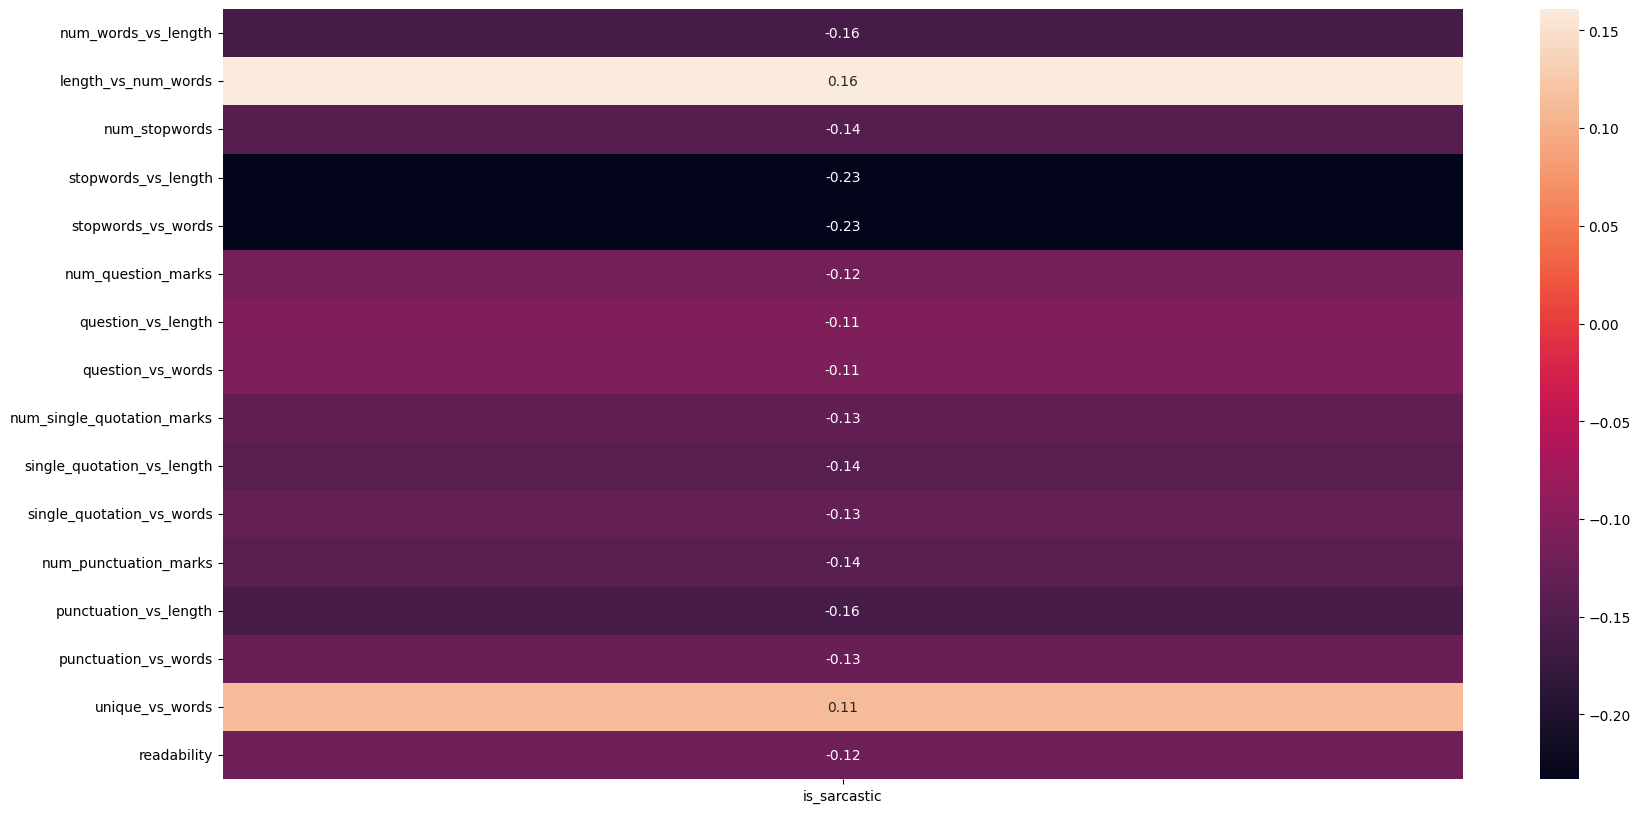

In [20]:
# set the threshold to be 0.1, meaning that the absolute value of correlation should at least 0.1 for at least one category
masking = list(map(lambda x: abs(max(train_correlations.iloc[x], key=abs))>0.1, range(len(train_correlations))))

# potentially useful features
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations[masking], annot=True)
plt.show()

In [28]:
print(train_correlations[masking].index)
print(f'the number of all features: {len(features_spacy)}\nthe number of potential features: {len(train_correlations[masking])}')

Index(['num_words_vs_length', 'length_vs_num_words', 'num_stopwords',
       'stopwords_vs_length', 'stopwords_vs_words', 'num_question_marks',
       'question_vs_length', 'question_vs_words', 'num_single_quotation_marks',
       'single_quotation_vs_length', 'single_quotation_vs_words',
       'num_punctuation_marks', 'punctuation_vs_length',
       'punctuation_vs_words', 'unique_vs_words', 'readability'],
      dtype='object')
the number of all features: 39
the number of potential features: 16


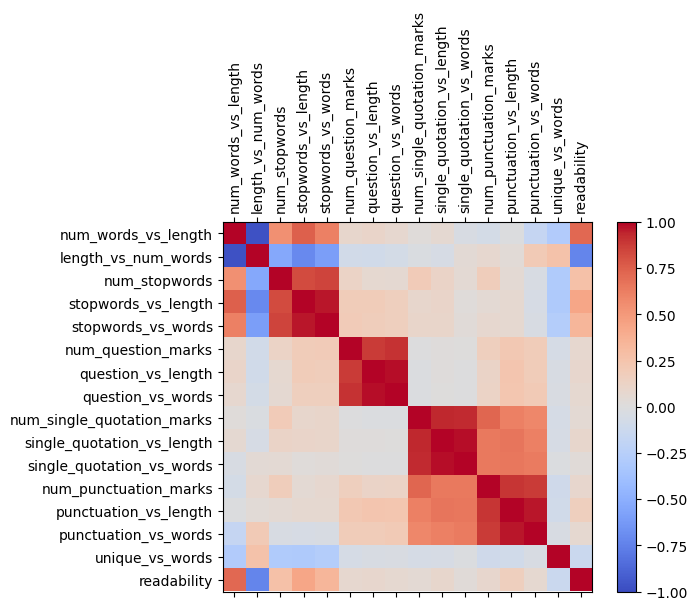

In [29]:
potential_features = ['num_words_vs_length', 'length_vs_num_words', 'num_stopwords',
       'stopwords_vs_length', 'stopwords_vs_words', 'num_question_marks',
       'question_vs_length', 'question_vs_words', 'num_single_quotation_marks',
       'single_quotation_vs_length', 'single_quotation_vs_words',
       'num_punctuation_marks', 'punctuation_vs_length',
       'punctuation_vs_words', 'unique_vs_words', 'readability']

correlation = feature_df_spacy[potential_features].corr()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(potential_features),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(potential_features)
ax.set_yticklabels(potential_features)
plt.show()
       

In [30]:
#Highly correlated features are subsequently removed. 
#removed_features = ['num_single_quotation_marks',
# 'single_quotation_vs_length', 'single_quotation_vs_words',
# 'num_punctuation_marks', 'punctuation_vs_length',
# 'punctuation_vs_words']
selected_features = ['num_words_vs_length', 'length_vs_num_words', 'num_stopwords',
       'stopwords_vs_length', 'stopwords_vs_words', 'num_question_marks',
       'question_vs_length', 'question_vs_words', 'unique_vs_words', 'readability']

feature_df_spacy[selected_features].describe()

,num_words_vs_length,length_vs_num_words,num_stopwords,stopwords_vs_length,stopwords_vs_words,num_question_marks,question_vs_length,question_vs_words,unique_vs_words,readability
count,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000
mean,0.164535,6.228922,2.886443,0.047551,0.274777,0.030926,0.000664,0.003748,0.957032,74.042663
std,0.025763,0.995897,1.941971,0.030556,0.147797,0.175696,0.004281,0.023611,0.086459,22.795185
min,0.063830,3.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-91.295000
25%,0.147059,5.545455,1.000000,0.026316,0.166667,0.000000,0.000000,0.000000,0.928571,61.240000
50%,0.162791,6.142857,3.000000,0.043478,0.272727,0.000000,0.000000,0.000000,1.000000,76.501538
75%,0.180328,6.800000,4.000000,0.064516,0.375000,0.000000,0.000000,0.000000,1.000000,89.516923
max,0.315789,15.666667,18.000000,0.315789,1.000000,2.000000,0.166667,0.666667,1.000000,121.558333


As length_vs_num_words, num_stopwords, and readability have larger scale than other variables, we need to perform scaling on these 3 variables.

<Axes: >

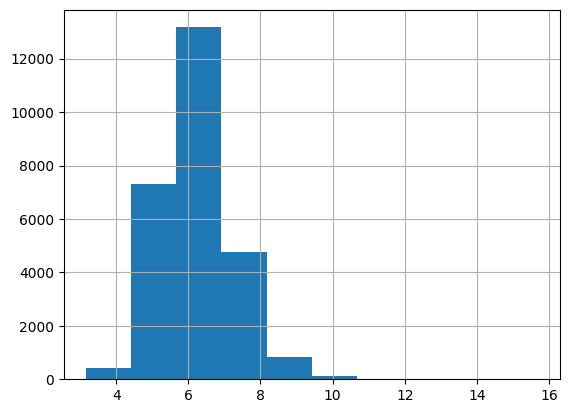

In [31]:
feature_df_spacy['length_vs_num_words'].hist()

<Axes: >

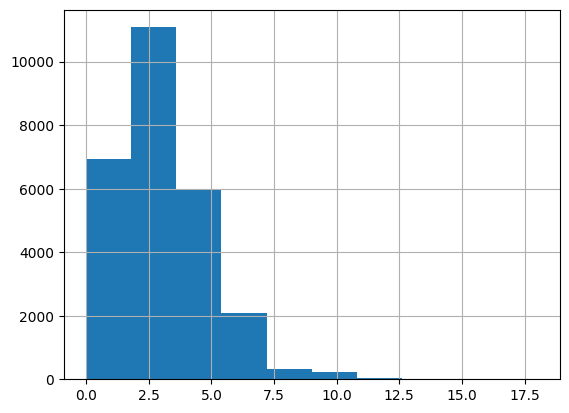

In [32]:
feature_df_spacy['num_stopwords'].hist()

<Axes: >

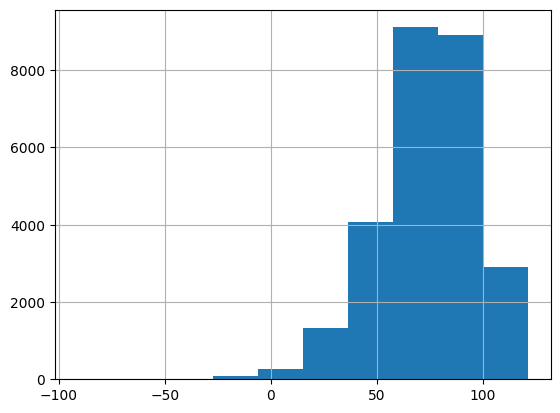

In [33]:
feature_df_spacy['readability'].hist()

In [ ]:
scaler = StandardScaler()
length_vs_num_words_scaled = scaler.fit_transform(feature_df_spacy[['length_vs_num_words']])
num_stopwords_scaled = scaler.fit_transform(feature_df_spacy[['num_stopwords']])
readability_scaled = scaler.fit_transform(feature_df_spacy[['readability']])
feature_df_spacy['length_vs_num_words_scaled'] = length_vs_num_words_scaled
feature_df_spacy['num_stopwords_scaled'] = num_stopwords_scaled
feature_df_spacy['readability_scaled'] = readability_scaled

/var/folders/7s/ygvbmhln7fj9794djrgz1z7c0000gn/T/ipykernel_49468/3732074096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_spacy['length_vs_num_words_scaled'] = length_vs_num_words_scaled
/var/folders/7s/ygvbmhln7fj9794djrgz1z7c0000gn/T/ipykernel_49468/3732074096.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df_spacy['num_stopwords_scaled'] = num_stopwords_scaled
/var/folders/7s/ygvbmhln7fj9794djrgz1z7c0000gn/T/ipykernel_49468/3732074096.py:7: SettingWithCopyWarning: 
A value i

In [41]:
selected_features = ['is_sarcastic', 'num_words_vs_length', 'length_vs_num_words_scaled', 'num_stopwords_scaled',
       'stopwords_vs_length', 'stopwords_vs_words', 'num_question_marks',
       'question_vs_length', 'question_vs_words', 'unique_vs_words', 'readability_scaled']

feature_df_spacy[selected_features].head()

,is_sarcastic,num_words_vs_length,length_vs_num_words_scaled,num_stopwords_scaled,stopwords_vs_length,stopwords_vs_words,num_question_marks,question_vs_length,question_vs_words,unique_vs_words,readability_scaled
0,0,0.153846,0.272200,-0.456474,0.025641,0.166667,0,0.0,0.0,1.000000,-0.275838
1,0,0.166667,-0.229869,1.603328,0.071429,0.428571,0,0.0,0.0,1.000000,0.165303
2,1,0.177215,-0.588490,1.088377,0.063291,0.357143,0,0.0,0.0,0.857143,0.430402
3,1,0.154762,0.233579,1.088377,0.059524,0.384615,0,0.0,0.0,1.000000,-0.099795
4,0,0.171875,-0.412440,0.058476,0.046875,0.272727,0,0.0,0.0,1.000000,0.519690


In [43]:
feature_df_spacy[['num_words_vs_length', 'length_vs_num_words_scaled', 'num_stopwords_scaled',
       'stopwords_vs_length', 'stopwords_vs_words', 'num_question_marks',
       'question_vs_length', 'question_vs_words', 'unique_vs_words', 'readability_scaled']].describe()

feature_df_spacy[selected_features].to_csv('data/selected_train.csv', index=False)